In [1]:
import pandas as pd
import numpy as np
import sympy as sym
from scipy.stats import norm
import matplotlib.pyplot as plt
import time as t

Implementations of functions needed in the hedging problem

### Global variables

In [2]:
MAX_ITERS = 100
ERROR = 10**-16
ERROR2 = 10**-7

# Functions for pricing derivatives

### Black-Scholes formula

Black-Scholes formula for pricing European calls:

$$C(S_t,t)=N(d_1)S_t-Ee^{-rT}N(d_2)$$

$$d_1=\frac{ln(S_t/E)+(r+\sigma^2/2)T}{\sigma\sqrt{T}}$$

$$d_2=d_1-\sigma\sqrt{T}$$

Where $N(\cdot) := $ Normal cdf, $T:=$ time to maturity (years), $S_t:=$ spot price, $E:=$ strike price, $r:=$ risk free interest rate, $\sigma:=$ volatility

In [3]:
def d1(S,E,T,r,v): return np.log(S/E)+(r+v**2/2)*(T/365)/(v*np.sqrt(T/365))
def d2(S,E,T,r,v): return d1(S,E,T,r,v)-v*np.sqrt(T/365)

def price_call_BS(S,E,T,r,v):
    # S: price of the underlying, E: excercise price, 
    # T: days to maturity, v: volatility (sigma)
    d_1 = d1(S,E,T,r,v)
    d_2 = d2(S,E,T,r,v)
    return S*norm.cdf(d_1)-E*np.exp(-r*T/365)*norm.cdf(d_2)

### The Greeks

For call options:

Delta: $$\Delta=\frac{\partial C}{\partial S}=N(d_1)$$
Gamma: $$\Gamma=\frac{\partial^2 C}{\partial S^2}=\frac{N'(d_1)}{S\sigma\sqrt{T}}$$
Vega: $$\nu=\frac{\partial C}{\partial \sigma}=SN'(d_1)\sqrt{T}$$

Where $N'(\cdot):=$ normal pdf

In [4]:
def delta_call(S,E,T,r,v): return norm.cdf(d1(S,E,T,r,v))
def gamma_call(S,E,T,r,v): return norm.pdf(d1(S,E,T,r,v))/(S*v*np.sqrt(T/365))
def vega_call(S,E,T,r,v): return S*norm.pdf(d1(S,E,T,r,v))*np.sqrt(T/365)

### Working examples

Let $S_t=100$, $E=100$, $T=30$, $r=0.05$, $\sigma=0.25$.
Price of a call with the above parameters and the corresponding greeks:

In [5]:
price_call_BS(100,100,30,0.05,0.25)

3.0626001437287442

In [6]:
delta_call(100,100,30,0.05,0.25)

0.5371175752016983

In [7]:
gamma_call(100,100,30,0.05,0.25)

0.0554205328109922

In [8]:
vega_call(100,100,30,0.05,0.25)

11.387780714587437

# Numerical methods

Solving the hedging problem, we need numerical methods. In particular, methods for solving equations of form $f(x)=0$. Two routines are implemented here: Newton's method and Bisection method.

### Newton's method

$$x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}$$

In [9]:
def newtons_method(f,x_n,e=ERROR2,N=MAX_ITERS,debug=False):
    # f: function, f(x) = 0 # x_n: initial guess
    # e: acceptable error # N: max iterations
    x = sym.symbols('x')
    df = lambda z: float( sym.diff(f(x),x).subs(x,z).evalf() )
    close_to = lambda x: (x > -e and x < e)
    for i in range(1,N+1):
        if close_to(f(x_n)):
            return x_n
        else:
            x_n = x_n - f(x_n)/df(x_n)
    if debug:
        print('Maximum iterations reached. Solution is NOT within the error bound.')
    return x_n

### Newton's method (vega derivative)

Here the Newton's method is tailored for solving implied volatility (i.e. the derivative is hardcoded). Note: $\nu=\partial C / \partial \sigma$

In [10]:
def newtons_method_E(f,x_n,S,E,T,r,e=ERROR2,N=MAX_ITERS,debug=False):
    # f: function, f(x) = 0 # x_n: initial guess
    # e: acceptable error # N: max iterations
    df = lambda x: vega_call(S,E,T,r,x) + ERROR
    close_to = lambda x: (x > -e and x < e)
    for i in range(1,N+1):
        if close_to(f(x_n)):
            return x_n
        else:
            x_n = x_n - f(x_n)/df(x_n)
    if debug:
        print('Maximum iterations reached. Solution is NOT within the error bound.')
    return x_n

### Bisection method

Bisection method is implemented for testing purposes. When solving implied volatility, bisection method has an obvious weakness: choosing the initial interval $I=[a,b]$.

In [11]:
def bisection_method(f,I,e=ERROR2,N=MAX_ITERS,debug=False):
    # f: function, f(x) = 0 # I: interval [a,b]
    # e: acceptable error # N: max iterations
    close_to = lambda x: (x > -e and x < e)
    a = I[0]
    b = I[1]
    for i in range(1,N+1):
        m = (a+b)/2
        if close_to(f(m)):
            return m
        elif f(a)*f(m) < 0:
            b = m
        else:
            a = m
    if debug:
        print('Maximum iterations reached. Solution is NOT within the error bound.')
    return m

### Working examples

Solving roots of $f(x)=3x^2-8x+2$

In [12]:
f = lambda x: 3*x**2-8*x+2

In [13]:
newtons_method(f,0)

0.279240779943871

In [14]:
newtons_method(f,2)

2.3874258868147122

In [15]:
bisection_method(f,(0,1))

0.27924078702926636

In [16]:
bisection_method(f,(2,3))

2.3874258995056152

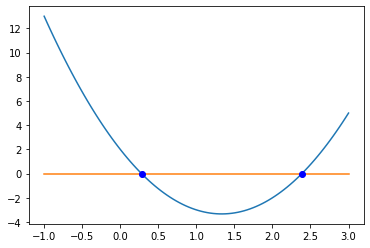

In [17]:
plt.plot(np.linspace(-1,3,100),f(np.linspace(-1,3,100)))
plt.plot(np.linspace(-1,3,100),np.zeros(100))
plt.plot(newtons_method(f,0),0,'bo')
plt.plot(bisection_method(f,(2,3)),0,'bo')

# Solving implied volatility

When the parameters of BS pricing function except $\sigma$ are known, we can solve equation (function of one parameter)

$$C(\sigma)=C_{Obs}$$


$$\iff C(\sigma)-C_{Obs}=0$$

With Newton's method (harcoded derivative)

$$\sigma_{n+1}=\sigma_n-\frac{C(..,\sigma_n)-C_{Obs}}{\nu(\sigma)}$$

In [18]:
def solve_implied_vola(C_obs,S,E,T,r):
    if pd.isna(C_obs): return C_obs
    f = lambda v: price_call_BS(S,E,T,r,v) - C_obs
    x_0 = 0.5
    return newtons_method_E(f,x_0,S,E,T,r)

### Working examples

In [19]:
solve_implied_vola(3,100,100,30,0.05)

0.2445027411336111

In [20]:
solve_implied_vola(0.5,100,100,30,0.05)

0.021163621342129065

# Functions for data

In [21]:
# Lag series in Pandas dataframe, e.g. set_rehedge_freq(2,[1,2,3,4,5,6]) -> [1,1,3,3,5,5]
def set_rehedge_freq(freq,series):
    series = series.tolist()
    for i,val in enumerate(series):
        if i % freq == 0:
            tmp = val
        else:
            series[i] = tmp
    return pd.Series(series)

In [22]:
set_rehedge_freq(2,pd.Series([1,2,3,4,5,6]))

0    1
1    1
2    3
3    3
4    5
5    5
dtype: int64

In [23]:
# Compute MSE (delta hedging with rehedging frequency = k) for an option with strike = E.
# data (dataframe of options with the same maturity) dictates the lenght of the period for which
# the MSE is computed
def MSE_delta_for_freq_strike(E,k,data):
    data['delta_freq'] = set_rehedge_freq(k,data['delta='+str(E)])
    data['hedge_pos']  = data.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
    data['change_P']   = data[E].diff()
    data['change_R']   = data['hedge_pos'].diff()
    data['MSE']        = data.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)
    return data['MSE'].sum()/data['MSE'].count() 

In [24]:
# Compute implied volatilies -> deltas for a dataframe of options
def volas_and_deltas_df(df_options,strikes):
    start = t.time()
    for E in strikes:
        name_vola = 'implied_vola='+str(E)
        name_delta = 'delta='+str(E)
        df_options[name_vola] = df_options.apply(lambda row: implied_vola_rows(E,row), axis=1)
        df_options[name_delta] = df_options.apply(lambda row: delta_rows(E,row), axis=1)
    end = t.time()
    print('>> Implied volas and deltas computed.')
    print('>> Time taken {} s'.format(end-start))
    return df_options